In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import datetime
from tensorflow.keras import layers, Model, regularizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class DataLoader:
    @staticmethod
    def process(file_path, seq_length=10):
        df = pd.read_csv(file_path)
        if 'Attack_label' not in df.columns:
            return None, None
        y, X = df['Attack_label'].values, df.drop(['Attack_label'], axis=1).values.astype(np.float32)
        n_seq = len(X) - seq_length + 1
        X_seq = np.array([X[i:i+seq_length] for i in range(n_seq)], dtype=np.float32)
        y_seq = np.array([y[i+seq_length-1] for i in range(n_seq)], dtype=np.int32)
        return X_seq, y_seq

class ANIDS:
    def __init__(self, input_shape, num_classes):
        os.makedirs("checkpoints", exist_ok=True)
        os.makedirs("performance_plots", exist_ok=True)
        self.input_shape, self.num_classes = input_shape, num_classes
        self.model = None
        self.params = {
            'filters': 28, 'kernel_size': 3, 'lstm_units': 29, 'dense_units': 19,
            'dropout_rate': 0.35, 'learning_rate': 7.9e-4, 'l2_reg': 2.9e-5, 'batch_size': 16
        }

    def create_model(self):
        inp = layers.Input(shape=self.input_shape)
        x = layers.Conv1D(self.params['filters'], self.params['kernel_size'], activation='relu', padding='same')(inp)
        # Added LayerNorm after Conv1D instead of BatchNorm
        x = layers.LayerNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(self.params['dropout_rate'])(x)
        x = layers.Bidirectional(layers.LSTM(self.params['lstm_units'], return_sequences=True))(x)
        # Added LayerNorm after LSTM
        x = layers.LayerNormalization()(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(self.params['dense_units'], activation='relu', kernel_regularizer=regularizers.l2(self.params['l2_reg']))(x)
        # Changed BatchNorm to LayerNorm
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(self.params['dropout_rate'])(x)
        out = layers.Dense(self.num_classes, activation='softmax')(x)
        model = Model(inp, out)
        model.compile(optimizer=tf.keras.optimizers.Adam(self.params['learning_rate']),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X, y):
        self.model = self.create_model()
        val_split = int(0.2 * len(X))
        X_tr, X_val, y_tr, y_val = X[:-val_split], X[-val_split:], y[:-val_split], y[-val_split:]
        tr_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).shuffle(10000).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
        hist = self.model.fit(tr_ds, validation_data=val_ds, epochs=30, verbose=1, callbacks=[
            # Updated EarlyStopping with patience=3 instead of 5
            EarlyStopping(patience=3, restore_best_weights=True),
            ModelCheckpoint("checkpoints/best_model.keras", save_best_only=True)
        ])
        self.plot_history(hist)
        return hist

    def plot_history(self, hist):
        p = "performance_plots/training_history.png"
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label='Train')
        plt.plot(hist.history['val_accuracy'], label='Val')
        plt.legend()
        plt.title("Accuracy")
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label='Train')
        plt.plot(hist.history['val_loss'], label='Val')
        plt.legend()
        plt.title("Loss")
        plt.grid()
        plt.tight_layout()
        plt.savefig(p)
        plt.show()

    def evaluate(self, X, y, k=3):
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        accs, mccs, yt_all, yp_all = [], [], [], []
        fig, axes = plt.subplots(1, k, figsize=(15, 4))
        for i, (tr, ts) in enumerate(kf.split(X)):
            K.clear_session()
            X_tr, X_te, y_tr, y_te = X[tr], X[ts], y[tr], y[ts]
            ds_tr = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
            ds_te = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
            model = self.create_model()
            model.fit(ds_tr, epochs=5, verbose=1)
            acc = model.evaluate(ds_te, verbose=1)[1]
            yp = np.argmax(model.predict(ds_te, verbose=1), axis=1)
            yt = np.argmax(y_te, axis=1)
            accs.append(acc)
            mccs.append(matthews_corrcoef(yt, yp))
            yt_all.extend(yt)
            yp_all.extend(yp)
            sns.heatmap(confusion_matrix(yt, yp), annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Fold {i+1}')
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("True")
        plt.tight_layout()
        plt.savefig("performance_plots/confusion_matrices.png")
        plt.show()

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(yt_all, yp_all), annot=True, fmt='d', cmap='Blues')
        plt.title("Overall Confusion Matrix")
        plt.savefig("performance_plots/overall_confusion_matrix.png")
        plt.show()

        rpt = classification_report(yt_all, yp_all)
        with open("performance_plots/classification_report.txt", 'w') as f:
            f.write(rpt)
        print(rpt)

        x = np.arange(k)
        plt.figure(figsize=(10, 6))
        plt.bar(x - 0.2, accs, width=0.4, label="Accuracy")
        plt.bar(x + 0.2, mccs, width=0.4, label="MCC")
        plt.xticks(x, [f"Fold {i+1}" for i in x])
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig("performance_plots/fold_performance.png")
        plt.show()

        return {
            'accuracy': {'mean': np.mean(accs), 'std': np.std(accs)},
            'mcc': {'mean': np.mean(mccs), 'std': np.std(mccs)}
        }

    def save(self):
        d = "saved_models"
        os.makedirs(d, exist_ok=True)
        p = os.path.join(d, f"model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.keras")
        self.model.save(p)
        return p

# For Jupyter execution - use these cells below

# Cell 1: Load data
file_path = "balanced_dataset_50k.csv"  # Change this to your file path
X, y = DataLoader.process(file_path, 10)
if X is None:
    raise ValueError("Invalid dataset. 'Attack_label' column not found.")
    
# Convert labels to categorical
labels = {l: i for i, l in enumerate(np.unique(y))}
y = tf.keras.utils.to_categorical([labels[i] for i in y])

# Cell 2: Split data and create model
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
nids = ANIDS(X_tr.shape[1:], y.shape[1])
print(f"Input shape: {X_tr.shape[1:]}, Classes: {y.shape[1]}")

# Cell 3: Train model
history = nids.train(X_tr, y_tr)

# Cell 4: Evaluate model
results = nids.evaluate(X_te, y_te)
print(f"Accuracy: {results['accuracy']['mean']:.4f} ± {results['accuracy']['std']:.4f}")
print(f"MCC: {results['mcc']['mean']:.4f} ± {results['mcc']['std']:.4f}")

# Cell 5: Save model
model_path = nids.save()
print(f"Model saved to {model_path}")

Input shape: (10, 52), Classes: 2
Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8976 - loss: 0.2856 - val_accuracy: 0.9895 - val_loss: 0.0409
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9849 - loss: 0.0544 - val_accuracy: 0.9945 - val_loss: 0.0232
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9901 - loss: 0.0375 - val_accuracy: 0.9950 - val_loss: 0.0192
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9940 - loss: 0.0254 - val_accuracy: 0.9966 - val_loss: 0.0127
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9938 - loss: 0.0255 - val_accuracy: 0.9971 - val_loss: 0.0096
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9949 - loss: 0.0198 - val_accuracy: 0.9979 - val_loss: 0.0081
Epoch 7/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9941 - loss: 0.0193 - val_accuracy: 0.9974 - val_loss: 0.0086
Epoch 8/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - 

KeyboardInterrupt: 

Input shape: (10, 52), Classes: 2
Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8507 - loss: 0.4033 - val_accuracy: 0.9887 - val_loss: 0.0481 - learning_rate: 7.9000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9813 - loss: 0.0780 - val_accuracy: 0.9954 - val_loss: 0.0281 - learning_rate: 7.9000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9919 - loss: 0.0412 - val_accuracy: 0.9960 - val_loss: 0.0242 - learning_rate: 7.9000e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9958 - loss: 0.0302 - val_accuracy: 0.9970 - val_loss: 0.0212 - learning_rate: 7.9000e-04
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9965 - loss: 0.0241 - val_accuracy: 0.9974 - val_loss: 0.0190 - learning_rate: 7.9000e-04
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9970 - loss: 0.0229 - val_accuracy: 0.9976 - val_loss: 0.0175 - learning_rate: 7.9000e-04
Epoch 7/15
1000/10

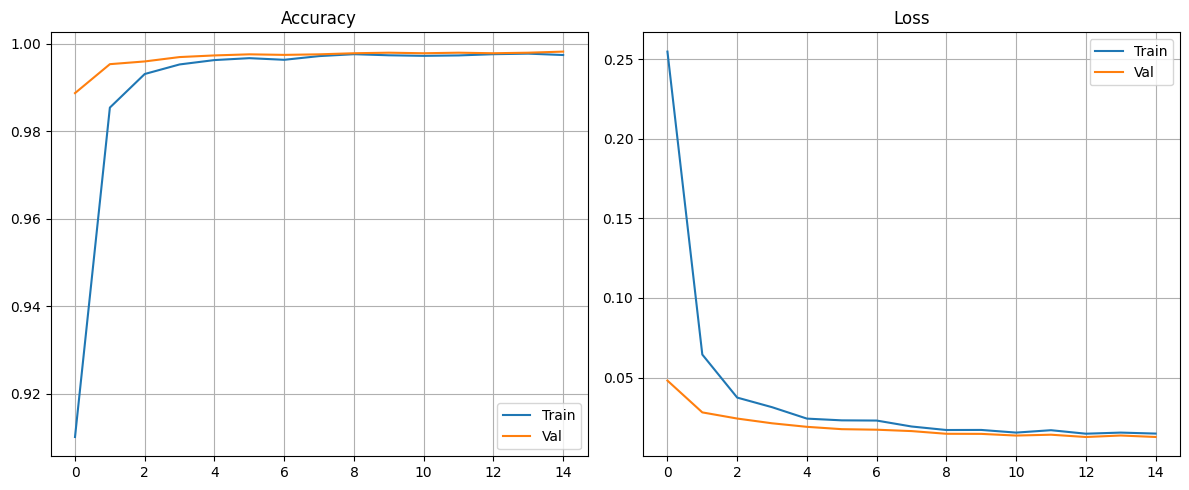

Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7984 - loss: 0.5819
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8431 - loss: 0.4215
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8880 - loss: 0.2709
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9527 - loss: 0.1539
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9721 - loss: 0.0999
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.9913 - loss: 0.0504
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7680 - loss: 0.6070
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8364 - loss: 0.4303
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8789 - loss: 0.2903
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9491 - loss: 0.1679
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9701 - loss: 0.1200
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 

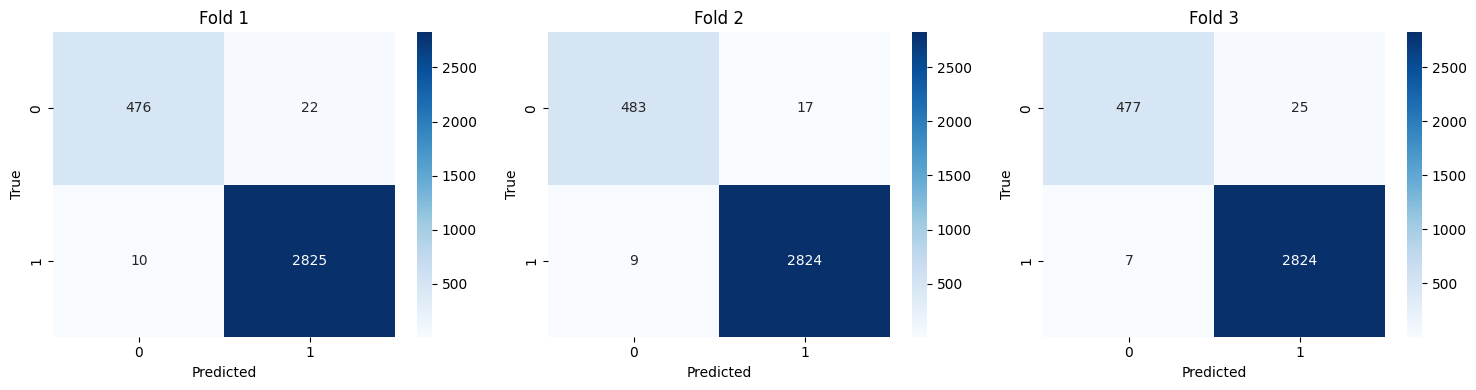

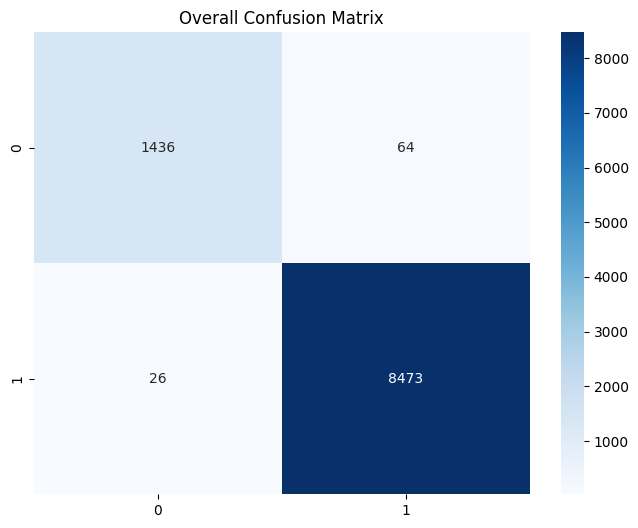

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1500
           1       0.99      1.00      0.99      8499

    accuracy                           0.99      9999
   macro avg       0.99      0.98      0.98      9999
weighted avg       0.99      0.99      0.99      9999



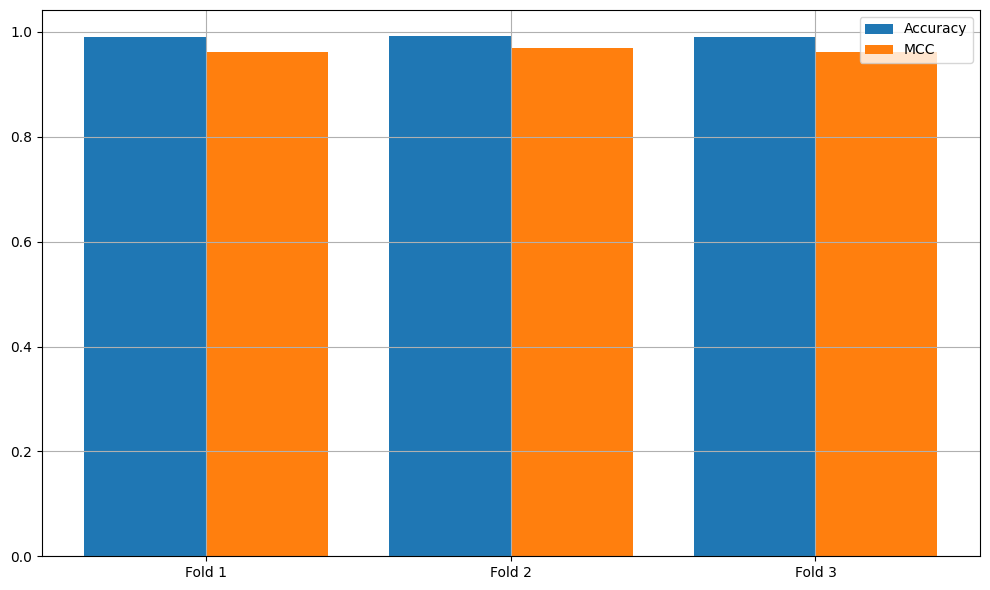

Accuracy: 0.9910 ± 0.0008
MCC: 0.9644 ± 0.0034
Model saved to saved_models/model_20250404_144414.keras


In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import datetime
from tensorflow.keras import layers, Model, regularizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class DataLoader:
    @staticmethod
    def process(file_path, seq_length=10):
        df = pd.read_csv(file_path)
        if 'Attack_label' not in df.columns:
            return None, None
        y, X = df['Attack_label'].values, df.drop(['Attack_label'], axis=1).values.astype(np.float32)
        # Apply standardization to features
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-7)
        n_seq = len(X) - seq_length + 1
        X_seq = np.array([X[i:i+seq_length] for i in range(n_seq)], dtype=np.float32)
        y_seq = np.array([y[i+seq_length-1] for i in range(n_seq)], dtype=np.int32)
        return X_seq, y_seq

class ANIDS:
    def __init__(self, input_shape, num_classes):
        os.makedirs("checkpoints", exist_ok=True)
        os.makedirs("performance_plots", exist_ok=True)
        self.input_shape, self.num_classes = input_shape, num_classes
        self.model = None
        # Reduced neurons by 20%
        self.params = {
            'filters': 22,              # Reduced from 28
            'kernel_size': 3,
            'lstm_units': 23,           # Reduced from 29
            'dense_units': 15,          # Reduced from 19
            'dropout_rate': 0.4,        # Increased from 0.35
            'learning_rate': 7.9e-4,
            'l2_reg': 5.0e-5,           # Increased from 2.9e-5
            'batch_size': 32            # Increased from 16
        }

    def create_model(self):
        inp = layers.Input(shape=self.input_shape)
        
        # Added Gaussian noise for data augmentation
        x = layers.GaussianNoise(0.1)(inp)
        
        x = layers.Conv1D(self.params['filters'], self.params['kernel_size'], 
                         activation='relu', padding='same', 
                         kernel_regularizer=regularizers.l2(self.params['l2_reg']))(x)
        x = layers.LayerNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(self.params['dropout_rate'])(x)
        
        x = layers.Bidirectional(layers.LSTM(self.params['lstm_units'], 
                                            return_sequences=True,
                                            kernel_regularizer=regularizers.l2(self.params['l2_reg']),
                                            recurrent_regularizer=regularizers.l2(self.params['l2_reg'])))(x)
        x = layers.LayerNormalization()(x)
        
        # Added spatial dropout for better feature independence
        x = layers.SpatialDropout1D(0.2)(x)
        
        # Use both average and max pooling for better feature extraction
        avg_pool = layers.GlobalAveragePooling1D()(x)
        max_pool = layers.GlobalMaxPooling1D()(x)
        x = layers.Concatenate()([avg_pool, max_pool])
        
        x = layers.Dense(self.params['dense_units'], 
                        activation='relu', 
                        kernel_regularizer=regularizers.l2(self.params['l2_reg']))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(self.params['dropout_rate'])(x)
        
        out = layers.Dense(self.num_classes, activation='softmax')(x)
        model = Model(inp, out)
        
        # Added gradient clipping to prevent exploding gradients
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.params['learning_rate'],
            clipnorm=1.0
        )
        
        model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
        return model

    def train(self, X, y):
        self.model = self.create_model()
        
        # Implement data stratification to ensure balanced classes
        val_split = int(0.2 * len(X))
        X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=np.argmax(y, axis=1),
                                                  random_state=42)
        
        # Data augmentation on training set
        def augment_data(x, y):
            # Add small random noise to input features
            noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.1)
            x = x + noise
            return x, y
        
        tr_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
        tr_ds = tr_ds.map(augment_data)  # Apply augmentation
        tr_ds = tr_ds.shuffle(10000).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
        
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
        
        # Add callbacks for better training
        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
            ModelCheckpoint("checkpoints/best_model.keras", save_best_only=True, monitor='val_loss'),
            # Add learning rate reduction on plateau
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
        ]
        
        # Reduced epochs from 30 to 15
        hist = self.model.fit(
            tr_ds, 
            validation_data=val_ds, 
            epochs=15,
            verbose=1, 
            callbacks=callbacks
        )
        
        self.plot_history(hist)
        return hist

    def plot_history(self, hist):
        p = "performance_plots/training_history.png"
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label='Train')
        plt.plot(hist.history['val_accuracy'], label='Val')
        plt.legend()
        plt.title("Accuracy")
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label='Train')
        plt.plot(hist.history['val_loss'], label='Val')
        plt.legend()
        plt.title("Loss")
        plt.grid()
        plt.tight_layout()
        plt.savefig(p)
        plt.show()

    def evaluate(self, X, y, k=3):
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        accs, mccs, yt_all, yp_all = [], [], [], []
        fig, axes = plt.subplots(1, k, figsize=(15, 4))
        for i, (tr, ts) in enumerate(kf.split(X)):
            K.clear_session()
            X_tr, X_te, y_tr, y_te = X[tr], X[ts], y[tr], y[ts]
            ds_tr = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
            ds_te = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(self.params['batch_size']).prefetch(tf.data.AUTOTUNE)
            model = self.create_model()
            model.fit(ds_tr, epochs=5, verbose=1)
            acc = model.evaluate(ds_te, verbose=1)[1]
            yp = np.argmax(model.predict(ds_te, verbose=1), axis=1)
            yt = np.argmax(y_te, axis=1)
            accs.append(acc)
            mccs.append(matthews_corrcoef(yt, yp))
            yt_all.extend(yt)
            yp_all.extend(yp)
            sns.heatmap(confusion_matrix(yt, yp), annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Fold {i+1}')
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("True")
        plt.tight_layout()
        plt.savefig("performance_plots/confusion_matrices.png")
        plt.show()

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(yt_all, yp_all), annot=True, fmt='d', cmap='Blues')
        plt.title("Overall Confusion Matrix")
        plt.savefig("performance_plots/overall_confusion_matrix.png")
        plt.show()

        rpt = classification_report(yt_all, yp_all)
        with open("performance_plots/classification_report.txt", 'w') as f:
            f.write(rpt)
        print(rpt)

        x = np.arange(k)
        plt.figure(figsize=(10, 6))
        plt.bar(x - 0.2, accs, width=0.4, label="Accuracy")
        plt.bar(x + 0.2, mccs, width=0.4, label="MCC")
        plt.xticks(x, [f"Fold {i+1}" for i in x])
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig("performance_plots/fold_performance.png")
        plt.show()

        return {
            'accuracy': {'mean': np.mean(accs), 'std': np.std(accs)},
            'mcc': {'mean': np.mean(mccs), 'std': np.std(mccs)}
        }

    def save(self):
        d = "saved_models"
        os.makedirs(d, exist_ok=True)
        p = os.path.join(d, f"model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.keras")
        self.model.save(p)
        return p

# For Jupyter execution - use these cells below

# Cell 1: Load data
file_path = "balanced_dataset_50k.csv"  # Change this to your file path
X, y = DataLoader.process(file_path, 10)
if X is None:
    raise ValueError("Invalid dataset. 'Attack_label' column not found.")
    
# Convert labels to categorical
labels = {l: i for i, l in enumerate(np.unique(y))}
y = tf.keras.utils.to_categorical([labels[i] for i in y])

# Cell 2: Split data and create model
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42)
nids = ANIDS(X_tr.shape[1:], y.shape[1])
print(f"Input shape: {X_tr.shape[1:]}, Classes: {y.shape[1]}")

# Cell 3: Train model
history = nids.train(X_tr, y_tr)

# Cell 4: Evaluate model
results = nids.evaluate(X_te, y_te)
print(f"Accuracy: {results['accuracy']['mean']:.4f} ± {results['accuracy']['std']:.4f}")
print(f"MCC: {results['mcc']['mean']:.4f} ± {results['mcc']['std']:.4f}")

# Cell 5: Save model
model_path = nids.save()
print(f"Model saved to {model_path}")

Evaluating model...
14880/14880 ━━━━━━━━━━━━━━━━━━━━ 13s 791us/step - accuracy: 0.9885 - loss: 0.0678
Test accuracy: 0.9889
Test loss: 0.0652
Making predictions...
14880/14880 ━━━━━━━━━━━━━━━━━━━━ 13s 732us/step

Performance Metrics:
Accuracy: 0.9889
Precision: 0.9905
Recall: 0.9889
F1-score: 0.9893
False Positive Rate: 0.0084

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     29080
           1       1.00      0.99      0.99    447055

    accuracy                           0.99    476135
   macro avg       0.92      0.99      0.96    476135
weighted avg       0.99      0.99      0.99    476135


Comparison with Literature:
Our Model - Accuracy: 0.9889, F1-score: 0.9893, FPR: 0.0084
Autoencoder+LSTM - Accuracy: 0.9888, F1-score: 0.9888, FPR: Not reported
CNN-BiLSTM (Ours) - Accuracy: 0.9922, F1-score: 0.9949, FPR: 0.0609

Execution completed successfully!
Results saved to 'test_classification_report.txt'
Confu

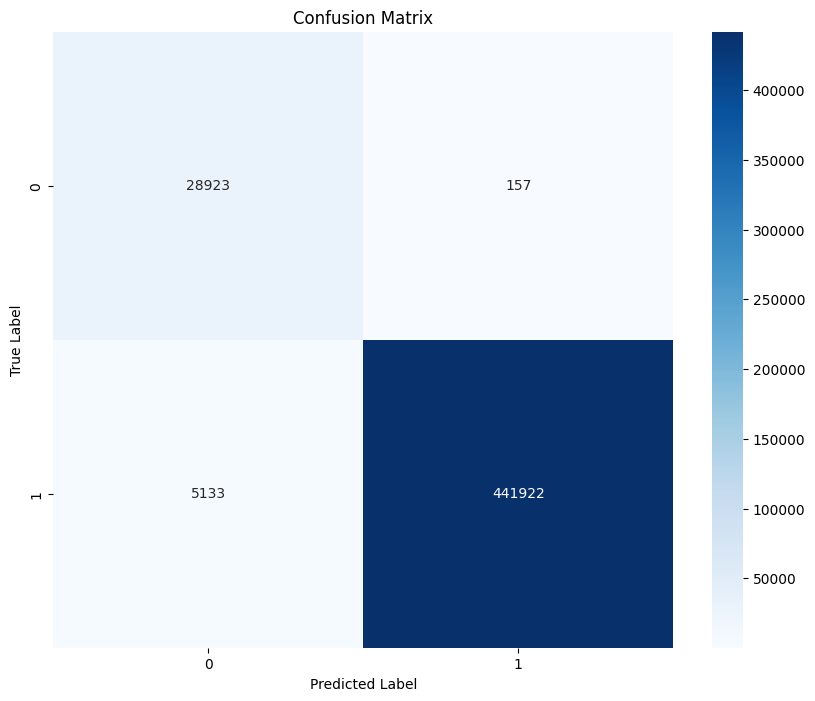

In [12]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support

def process_test_data(file_path, seq_length=10):
    df = pd.read_csv(file_path)
    
    # Check for 'Attack_label' column
    if 'Attack_label' not in df.columns:
        print("Warning: 'Attack_label' column not found. Running in prediction-only mode.")
        
        # Handle potential string columns (like IP addresses)
        string_columns = df.select_dtypes(include=['object']).columns
        if len(string_columns) > 0:
            print(f"Found string columns: {string_columns}. These will be dropped.")
            df = df.drop(columns=string_columns)
        
        X = df.values.astype(np.float32)
        # Apply standardization
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-7)
        n_seq = len(X) - seq_length + 1
        X_seq = np.array([X[i:i+seq_length] for i in range(n_seq)], dtype=np.float32)
        return X_seq, None
    else:
        # Extract labels first
        y = df['Attack_label'].values
        
        # Remove label column and identify string columns
        df_features = df.drop(['Attack_label'], axis=1)
        string_columns = df_features.select_dtypes(include=['object']).columns
        
        if len(string_columns) > 0:
            print(f"Found string columns: {string_columns}. These will be dropped.")
            df_features = df_features.drop(columns=string_columns)
        
        X = df_features.values.astype(np.float32)
        
        # Apply standardization
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-7)
        n_seq = len(X) - seq_length + 1
        X_seq = np.array([X[i:i+seq_length] for i in range(n_seq)], dtype=np.float32)
        y_seq = np.array([y[i+seq_length-1] for i in range(n_seq)], dtype=np.int32)
        return X_seq, y_seq

def test_model(model_path, test_file_path, seq_length=10):
    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Process test data
    X_test, y_test = process_test_data(test_file_path, seq_length)
    
    # If no labels available, just make predictions
    if y_test is None:
        print("No labels available in test data. Running prediction only.")
        predictions = model.predict(X_test)
        pred_classes = np.argmax(predictions, axis=1)
        
        # Save predictions to file
        pd.DataFrame({
            'predicted_class': pred_classes,
            'confidence': np.max(predictions, axis=1)
        }).to_csv('test_predictions.csv', index=False)
        
        print(f"Predictions saved to 'test_predictions.csv'")
        return None
    
    # Convert labels to categorical if they aren't already
    if len(y_test.shape) == 1:
        # Get unique labels
        unique_labels = np.unique(y_test)
        label_map = {l: i for i, l in enumerate(unique_labels)}
        y_test_numeric = np.array([label_map[y] for y in y_test])
        y_test_cat = tf.keras.utils.to_categorical(y_test_numeric)
    else:
        y_test_cat = y_test
        y_test_numeric = np.argmax(y_test, axis=1)
    
    # Create a batch dataset
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat)).batch(32).prefetch(tf.data.AUTOTUNE)
    
    # Evaluate model
    print("Evaluating model...")
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    # Make predictions
    print("Making predictions...")
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_numeric, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_numeric, y_pred, average='weighted')
    
    # False positive rate calculation
    cm = confusion_matrix(y_test_numeric, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    FPR = FP / (FP + TN)
    avg_fpr = np.mean(FPR)
    
    # Print results
    print("\nPerformance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Positive Rate: {avg_fpr:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('test_confusion_matrix.png')
    
    # Save detailed classification report
    report = classification_report(y_test_numeric, y_pred)
    print("\nClassification Report:")
    print(report)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write("Model Test Results\n")
        f.write("=================\n\n")
        f.write(f"Model path: {model_path}\n")
        f.write(f"Test data: {test_file_path}\n\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"False Positive Rate: {avg_fpr:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
    
    # Compare to metrics from literature
    literature_metrics = {
        "Autoencoder+LSTM": {"Accuracy": 0.9888, "F1_score": 0.9888, "Computational_Efficiency": "Heavy", "FPR": "Not reported"},
        "CNN-BiLSTM (Ours)": {"Accuracy": 0.9922, "F1_score": 0.9949, "Computational_Efficiency": "Relatively heavier", "FPR": 0.0609}
    }
    
    print("\nComparison with Literature:")
    print(f"Our Model - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, FPR: {avg_fpr:.4f}")
    for model_name, metrics in literature_metrics.items():
        print(f"{model_name} - Accuracy: {metrics['Accuracy']:.4f}, F1-score: {metrics['F1_score']:.4f}, FPR: {metrics['FPR']}")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "false_positive_rate": avg_fpr
    }

if __name__ == "__main__":
    # Configuration
    MODEL_PATH = "/Users/siddhantgond/Desktop/inputsFile/saved_models/model_20250404_144414.keras"
    TEST_FILE = "/Users/siddhantgond/Desktop/inputsFile/processed_dataset_iteration_2.csv" 
    SEQ_LENGTH = 10
    
    # Run the test
    results = test_model(MODEL_PATH, TEST_FILE, SEQ_LENGTH)
    
    if results:
        print("\nExecution completed successfully!")
        print(f"Results saved to 'test_classification_report.txt'")
        print(f"Confusion matrix visualization saved to 'test_confusion_matrix.png'")